# KDE

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm, gamma, expon, beta, rayleigh, weibull_min
from sklearn.model_selection import KFold

In [35]:
def kde(data, x, bandwidth, kernel='gaussian'):
    """Kernel density estimation."""
    if kernel == 'gaussian':
        kernel_func = norm.pdf
    elif kernel == 'gamma':
        """ 
When using the gamma.pdf function from the SciPy library, the parameter a represents the shape parameter of the gamma distribution. 
Setting the parameter nicely depends on the specific characteristics of the data and the desired shape of the distribution.
Maximum Likelihood Estimation (MLE): The SciPy library provides the gamma.fit function, 
which can estimate the parameters of the gamma distribution using maximum likelihood estimation. 
This function returns the shape parameter a along with the other parameters of the distribution. 
        
        """
        # Estimate the parameters using maximum likelihood estimation
        a_est, loc_est, scale_est = gamma.fit(data)
        kernel_func = gamma.pdf
    elif kernel == 'exponential':
        kernel_func = expon.pdf
    elif kernel == 'beta':
        """ 
When using the beta.pdf function from the SciPy library, the parameters a and b represent the shape parameters of 
the beta distribution. Setting these parameters nicely depends on the specific characteristics of 
the data and the desired shape of the distribution. 

Maximum Likelihood Estimation (MLE): The SciPy library provides the beta.fit function, which can estimate the parameters of 
the beta distribution using maximum likelihood estimation. 
This function returns the shape parameters a and b along with the other parameters of the distribution.   

        """
        # Estimate the parameters using maximum likelihood estimation
        a_est, b_est, loc_est, scale_est = beta.fit(data)
        kernel_func = beta.pdf
    elif kernel == 'rayleigh':
        kernel_func = rayleigh.pdf
    elif kernel == 'weibull':
        """
 
When using the weibull_min.pdf function from the SciPy library, the parameter a represents the shape parameter 
of the Weibull distribution. Setting this parameter nicely depends on the specific characteristics of the data and t
he desired shape of the distribution.   

 Maximum Likelihood Estimation (MLE): The SciPy library provides the weibull_min.fit function, which can estimate the parameters
of the Weibull distribution using maximum likelihood estimation. 
 This function returns the shape parameter a along with the other parameters of the distribution.   
        """
        # Estimate the parameters using maximum likelihood estimation
        a_est, loc_est, scale_est = weibull_min.fit(data)
        kernel_func = weibull_min.pdf
    else:
        raise ValueError("Invalid kernel. Supported kernels: 'gaussian', 'gamma', 'exponential', 'beta', 'rayleigh', 'weibull'.")

    n = len(data)
    density = np.zeros_like(x)
    
    for i in range(n):
        if kernel == 'gamma':
            density += kernel_func(((x - data[i]) / bandwidth),a=a_est)
        elif kernel == 'beta':
            density += kernel_func(((x - data[i]) / bandwidth),a=a_est,b=b_est)
        elif kernel == 'weibull':
            density += kernel_func(((x - data[i]) / bandwidth),c=a_est)
        else:
            density += kernel_func((x - data[i]) / bandwidth)
            
    density /= (n * bandwidth)

    return density
    
def true_density(data,kernel):
    if kernel == 'gaussian':
        density = norm.pdf(data, 0, 1) 
    elif kernel == 'gamma':
        density = gamma.pdf(data, 2, scale=1.5)
    elif kernel == 'exponential':
        density = expon.pdf(data, scale=2)
    elif kernel == 'beta':
        density = beta.pdf(data, 2, 5)
    elif kernel == 'rayleigh':
        density = rayleigh.pdf(data, scale=1)
    elif kernel == 'weibull':
        density = weibull_min.pdf(data, 2)
    else:
        raise ValueError("Invalid kernel. Supported kernels: 'gaussian', 'gamma', 'exponential', 'beta', 'rayleigh', 'weibull'.")
    
    return density

In [36]:
# Generate some random data
np.random.seed(42)
data_gaussian = np.random.normal(0, 1, 500)
data_gamma = np.random.gamma(2, 1.5, 300)
data_exponential = np.random.exponential(2, 400)
data_beta = np.random.beta(2, 5, 350)
data_rayleigh = np.random.rayleigh(1, 250)
data_weibull = np.random.weibull(2, 300)

# Add outliers to the data
num_outliers = 150
data_gaussian_outliers = np.concatenate([data_gaussian, np.random.normal(10, 5, num_outliers)])
data_gamma_outliers = np.concatenate([data_gamma, np.random.gamma(10, 2, num_outliers)])
data_exponential_outliers = np.concatenate([data_exponential, np.random.exponential(6, num_outliers)])
data_beta_outliers = np.concatenate([data_beta, np.random.beta(5, 2, num_outliers)])
data_rayleigh_outliers = np.concatenate([data_rayleigh, np.random.rayleigh(2, num_outliers)])
data_weibull_outliers = np.concatenate([data_weibull, np.random.weibull(2, num_outliers)])


data = np.concatenate([data_gaussian_outliers, data_gamma_outliers, data_exponential_outliers, data_beta_outliers,data_rayleigh_outliers,data_weibull_outliers])

# Define the range of values for which to estimate the density
#x = np.linspace(-5, 10, 1000)
x = np.linspace(-15, 40, 1000)

# Estimate density using different kernels
bandwidth = 0.5

In [37]:
kernels = ['gaussian', 'gamma', 'exponential', 'beta', 'rayleigh', 'weibull']
density_estimates = []

for kernel, data_dist in zip(kernels, [data_gaussian_outliers,data_gamma_outliers,data_exponential_outliers,data_beta_outliers,data_rayleigh_outliers,data_weibull_outliers]):
    density = kde(data_dist, x, bandwidth, kernel=kernel)
    density_estimates.append(density)

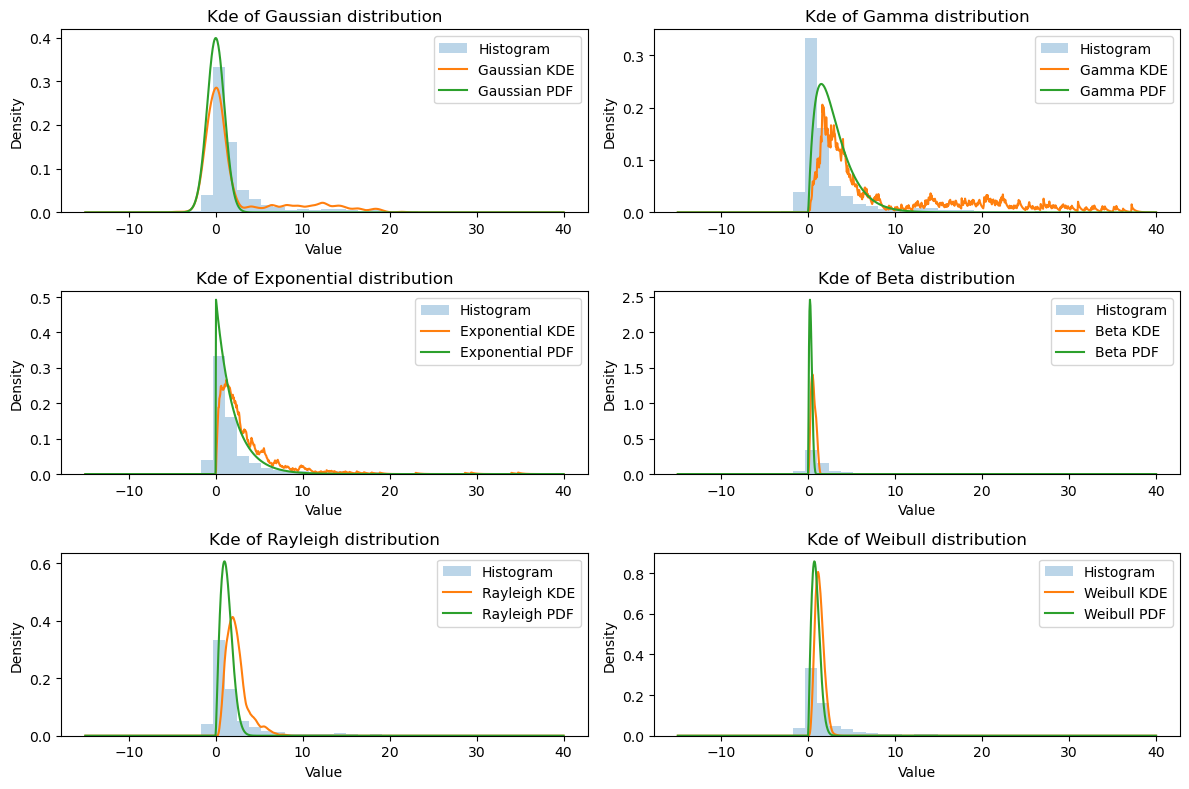

In [38]:
def plot_kde(kernels,density_estimates,title):
    # Plot all the densities in a subplot
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))

    for i , (kernel, density) in enumerate(zip(kernels, density_estimates)) :
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.hist(data, bins=30, density=True, alpha=0.3, label='Histogram')
        ax.plot(x, density, label=f'{kernel.capitalize()} KDE')
        
        # Plot the true data distributions
        ax.plot(x, true_density(x,kernel), label=f'{kernel.capitalize()} PDF')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.set_title('{} of {} distribution'.format(title,kernel.capitalize()))
        ax.legend()

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()
plot_kde(kernels,density_estimates,"KDE")


# RKDE

In [39]:
def robust_kde(data, x, kernel='gaussian', num_iterations=10, alpha=0.5):
    """Robust Kernel density estimation using IRLS algorithm."""
    n = len(data)
    weights = np.ones(n)
    robust_density = np.zeros_like(x)

    if num_iterations == 0:
        return kde(data, x, bandwidth=1.0, kernel=kernel)

    density = kde(data, x, bandwidth=1.0, kernel=kernel)

    # Calculate the residuals
    residuals = np.abs(data[:, np.newaxis] - x)

    # Update the weights using the robust M-estimator
    weights = np.power(np.maximum(1 - np.power(residuals / alpha, 2), 0), 2)

    # Calculate the weighted sum of densities
    weighted_density = np.sum(density * weights, axis=0)

    # Normalize the density estimate
    robust_density = weighted_density / np.sum(weights, axis=0)

    return robust_kde(data, x, kernel=kernel, num_iterations=num_iterations-1, alpha=alpha)
    

In [40]:
# Apply robust KDE using IRLS algorithm recursively
robust_density_estimates = []

for kernel, data_dist in zip(kernels, [data_gaussian, data_gamma, data_exponential, data_beta, data_rayleigh, data_weibull]):
    robust_density = robust_kde(data_dist, x, kernel=kernel, num_iterations=10, alpha=0.5)
    robust_density_estimates.append(robust_density)
    

/var/folders/8w/2xbr887j59s7gdhh09sj08w40000gp/T/ipykernel_8339/2473046633.py:22: RuntimeWarning: invalid value encountered in divide
  robust_density = weighted_density / np.sum(weights, axis=0)


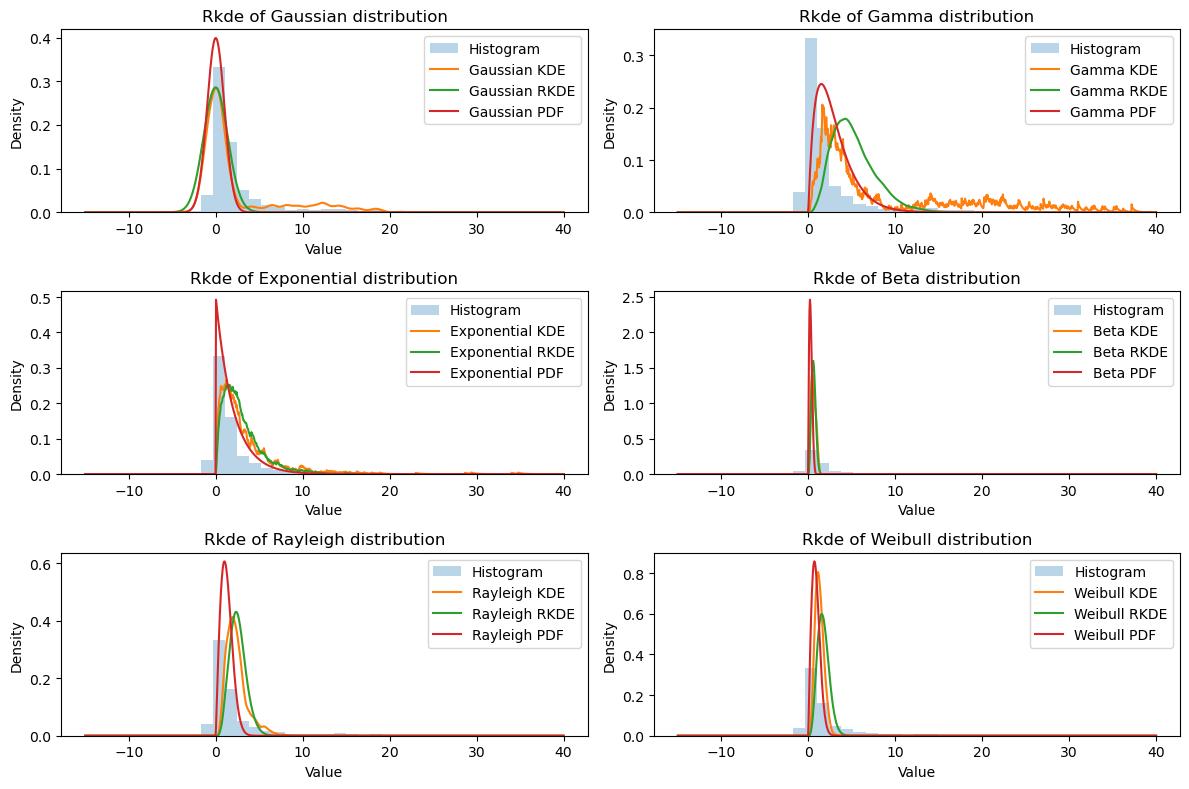

In [41]:
def plot_rkde(kernels,density_estimates,robust_density_estimates,title):
    # Plot all the densities in a subplot
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))

    for i , (kernel, density, rkde_density) in enumerate(zip(kernels, density_estimates,robust_density_estimates)) :
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.hist(data, bins=30, density=True, alpha=0.3, label='Histogram')
        ax.plot(x, density, label=f'{kernel.capitalize()} KDE')
        ax.plot(x, rkde_density, label=f'{kernel.capitalize()} RKDE')
        
        # Plot the true data distributions
        ax.plot(x, true_density(x,kernel), label=f'{kernel.capitalize()} PDF')
        """ if kernel == 'gaussian':
            ax.plot(x, norm.pdf(x, 0, 1), label=f'{kernel.capitalize()} PDF')  
        elif kernel == 'gamma':
            ax.plot(x, gamma.pdf(x, 2, scale=1.5), label=f'{kernel.capitalize()} PDF')
        elif kernel == 'exponential':
            ax.plot(x, expon.pdf(x, scale=2), label=f'{kernel.capitalize()} PDF')
        elif kernel == 'beta':
            ax.plot(x, beta.pdf(x, 2, 5), label=f'{kernel.capitalize()} PDF')
        elif kernel == 'rayleigh':
            ax.plot(x, rayleigh.pdf(x, scale=1), label=f'{kernel.capitalize()} PDF')
        elif kernel == 'weibull':
            ax.plot(x, weibull_min.pdf(x, 2), label=f'{kernel.capitalize()} PDF')
        else:
            raise ValueError("Invalid kernel. Supported kernels: 'gaussian', 'gamma', 'exponential', 'beta', 'rayleigh', 'weibull'.")
         """
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.set_title('{} of {} distribution'.format(title,kernel.capitalize()))
        ax.legend()

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()
plot_rkde(kernels,density_estimates,robust_density_estimates, "RKDE")

# Optimize the bandwith by apply PSO

When using Particle Swarm Optimization (PSO) to search for the optimal bandwidth in kernel density estimation (KDE) with the Unbiased Cross-Validation (UCV) function, the following steps can be followed:

Define the Particle:

Each particle in the swarm represents a potential bandwidth value for the KDE.
The position of each particle represents a candidate bandwidth value.
The velocity of each particle represents the magnitude and direction of its movement in the search space.
Initialize the Swarm:

Create a population of particles with random positions and velocities.
Assign an initial fitness value to each particle based on the UCV function.
Update Particle Velocity and Position:

Update the velocity of each particle based on its current velocity, its best position (pbest), and the best position among all particles in the swarm (gbest).
Update the position of each particle based on its current position and velocity.
Evaluate Particle Fitness:

Calculate the fitness of each particle using the UCV function.
The UCV function estimates the quality of the KDE by assessing its ability to generalize to unseen data points.
The fitness value represents the performance of the KDE with the corresponding bandwidth value.
Update Particle Best Position (pbest) and Global Best Position (gbest):

Compare the fitness of each particle with its previous best fitness (pbest) and update pbest if the new fitness is better.
Determine the particle with the best fitness value in the swarm and update the gbest if necessary.
Repeat Steps 3-5 until convergence:

Iteratively update particle velocities, positions, and fitness values.
Terminate the algorithm when a convergence criterion is met, such as a maximum number of iterations or a desired level of fitness improvement.
Retrieve the Optimal Bandwidth:

After convergence, the bandwidth value corresponding to the gbest position represents the optimal bandwidth for the KDE.
It's worth noting that the UCV function can be customized based on your specific requirements and the characteristics of the data. The fitness evaluation should reflect the performance of the KDE in generalizing to unseen data points, taking into account factors such as bias, variance, and overall estimation accuracy.

Implementing the above steps in code involves setting up the PSO algorithm, defining the UCV function, initializing the swarm, updating particle velocities and positions, evaluating fitness, and determining the optimal bandwidth based on the gbest position.

PSO can be a powerful optimization technique for finding the optimal bandwidth in KDE with the UCV function. However, it's important to consider the computational complexity of the UCV function, the population size, the convergence criteria, and the number of iterations to strike a balance between accuracy and computational efficiency.

In [42]:
# Define LS-UCV Fitness Function
def ls_ucv_fitness(data,bandwidth):
    """ n = len(data)
    h = bandwidth
    kfold = KFold(n_splits=2, shuffle=True)
    mse = 0.0

    for train_indices, test_indices in kfold.split(data):
        train_data = data[train_indices]
        test_data = data[test_indices]

        kde = gaussian_kde(train_data, bw_method=h)

        kde_estimation = kde.evaluate(test_data)
        kde_train_estimation = kde.evaluate(train_data)

        mse += np.mean((kde_estimation - kde_train_estimation) ** 2)

    mse /= 5.0 """
    def delta(X1,X2,h):
        return ((X1-X2) / h)**2

    n = len(data)
    d = len(bandwidth)
    print("n value {} and d value {}".format(n,d))
    prod_bandwiths = np.prod(bandwidth)
    operande1 = 1/ (2* np.sqrt(np.pi)**(d) * n**(2) * prod_bandwiths)
    sum1 = []
    for i in range(n):
        sum2 = []
        for j in range(n):
            if j == i : continue
            deltas = []
            for k in range(d):
                deltas.append((delta(data[i],data[j],bandwidth[k])))
            sum_deltas = np.sum(deltas)
            result = np.exp((-1/4)* sum_deltas) - ((2 * 2**(d/2)) * np.exp((-1/2)* sum_deltas))
            sum2.append(result)
        sum1.append(np.sum(sum2))
    operande2 =  1/ (2* np.sqrt(np.pi)**(d) * n * prod_bandwiths) * np.sum(sum1)

    final_result = operande1 + operande2
    return final_result
    #true_density = true_density()
    #return mse

# Define the Particle class
class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.best_position = position
        #self.best_fitness = float('inf')
        self.best_fitness = 100

In [43]:
# Define the PSO algorithm for bandwidth selection
def pso_bandwidth_selection(data, kernel='gaussian', num_particles=3, num_iterations=100, inertia=0.8, cognitive_weight=2.8, social_weight=2.05):
    '''Giving the Probability Density Function

    Parameters
    ----------
        data (Array):
        kernel (String):
        num_particles (Int):

    Returns
    -------
        ndrray: Gaussian distribution
    '''
    # Define the search space (bandwidth range)
    bandwidth_min = 0.01
    bandwidth_max = 1.0

    # Initialize the swarm
    swarm = []
    best_global_position = None
    best_global_fitness = float('inf')

    for _ in range(num_particles):
        position = np.random.uniform(bandwidth_min, bandwidth_max)
        velocity = np.random.uniform(-0.1, 0.1)
        particle = Particle(position, velocity)
        swarm.append(particle)
        # Update the global best position and fitness
        if particle.best_fitness < best_global_fitness:
            best_global_position = particle.best_position
            best_global_fitness = particle.best_fitness
            
    # PSO main loop
    for iter in range(num_iterations):
        print("Iter : {}".format(iter))
        for particle in swarm:
            # Update the velocity
            particle.velocity = (inertia * particle.velocity +
                                 cognitive_weight * np.random.uniform(0, 1) * (particle.best_position - particle.position) +
                                 social_weight * np.random.uniform(0, 1) * (best_global_position - particle.position))

            # Update the position
            particle.position += particle.velocity

            # Ensure the position stays within the search space
            particle.position = np.clip(particle.position, bandwidth_min, bandwidth_max)

            # Evaluate fitness
            #fitness = ucv(data, particle.position)
            print(particle.position)
            fitness = ls_ucv_fitness(data,[particle.position])
            # Update particle's best position and fitness
            if fitness < particle.best_fitness:
                particle.best_position = particle.position
                particle.best_fitness = fitness

                # Update global best position and fitness
                if particle.best_fitness < best_global_fitness:
                    best_global_position = particle.best_position
                    best_global_fitness = particle.best_fitness
            print("fitness value {}".format(fitness))
    # Retrieve the optimal bandwidth
    optimal_bandwidth = best_global_position

    return optimal_bandwidth

In [44]:
density_estimates = []

for kernel, data_dist in zip(kernels, [data_gaussian_outliers,data_gamma_outliers,data_exponential_outliers,data_beta_outliers,data_rayleigh_outliers,data_weibull_outliers]):
    optimal_bandwidth = pso_bandwidth_selection(data_dist, kernel=kernel,num_iterations=2)
    print("Optimal bandwith for {}: {}".format(kernel,optimal_bandwidth))
    density = kde(data_dist, x, optimal_bandwidth, kernel=kernel)
    density_estimates.append(density)

plot_kde(kernels,density_estimates,"KDE with PSO")

Iter : 0
0.8500727640671467
n value 650 and d value 1
fitness value -111.78721409392857
1.0
n value 650 and d value 1
fitness value -108.61072330721223
1.0
n value 650 and d value 1
fitness value -108.61072330721223
Iter : 1
0.8662077668166893
n value 650 and d value 1
fitness value -111.47354474877137
1.0
n value 650 and d value 1
fitness value -108.61072330721223
1.0
n value 650 and d value 1
fitness value -108.61072330721223
Optimal bandwith for gaussian: 0.8500727640671467
Iter : 0
0.9598637773514971
n value 450 and d value 1
fitness value -34.246791651533
1.0
n value 450 and d value 1
fitness value -34.12868443287394
1.0
n value 450 and d value 1
fitness value -34.12868443287394
Iter : 1
0.9295983667270846
n value 450 and d value 1
fitness value -34.331956998946524
1.0
n value 450 and d value 1
